In [46]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.coronawarn.app/assets/img/icons/favicon-192x192.png")

Erklärtes Ziel der Corona-Warn-App ist es unter Wahrung der Privatsphäre dabei zu helfen, Infektionsketten nachzuverfolgen und schnell zu unterbrechen. Davor, aber auch im Zuge ihres Releases im Google Play Store hat sie viele Befürworter, aber auch Gegenstimmen gewonnen. Um Infektionen möglichst flächendeckend zu verhindern, ist es wichtig, dass möglichst viele Nutzer*innen sie langfristig nutzen. Um dieser Aufgabe gerecht zu werden, ist es daher notwendig, Beschwerden ("App-Reviews") Gehör zu verschaffen, um Fehler, Bugs und andere Unzunehmlichkeiten, die die Nutzung der App wenig attraktiv gestalten, zu verhindern. Hier sollen mithilfe von Topic Modeling, Themen herausgearbeitet werden, die sich aus den Reviews mit einer schlechten Bewertung ("1" von "1" bis "5") ergeben um nutzerspezifische Bedürfnisse zu addressieren.

# Daten aus dem Google Play Store herunterladen und als data frame speichern

In [1]:
#from google_play_scraper import app, Sort, reviews_all, reviews

In [2]:
#result, continuation_token = reviews(
#     'de.rki.coronawarnapp',
#     lang = 'de', # defaults to 'en'
#     country = 'de', # defaults to 'us'
#     sort = Sort.NEWEST, # defaults to Sort.MOST_RELEVANT,
#     count = 20000
# )

In [3]:
#df = pd.DataFrame(result)
#df

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [5]:
#df.to_csv('rki_corona.csv')
df = pd.read_csv('google_play_corona_warn_app.csv', index_col=[0])

# Explorative Datenanalyse

Zuallererst machen wir uns ein Bild von den uns vorliegenden Daten, das heißt wir betrachten die Ratings der Versionen, aber auch die generelle Verteilung der Ratings.

In [6]:
df.loc[:, df.isnull().any()].columns

Index(['reviewCreatedVersion', 'replyContent', 'repliedAt'], dtype='object')

In [7]:
df_version = df[["score", "reviewCreatedVersion"]].groupby("reviewCreatedVersion").mean()
df_version.reset_index(level=0, inplace=True)

In [8]:
# Only show versions with >= 50 ratings
df_version_filter = df[["score", "reviewCreatedVersion"]].groupby("reviewCreatedVersion").describe()["score"]
df_version_filter.reset_index(level=0, inplace=True)
df_version_filter = df_version_filter[df_version_filter["count"] >= 50]

mask_version = df_version_filter["reviewCreatedVersion"]
df_version_filter = df[df["reviewCreatedVersion"].isin(mask_version)]

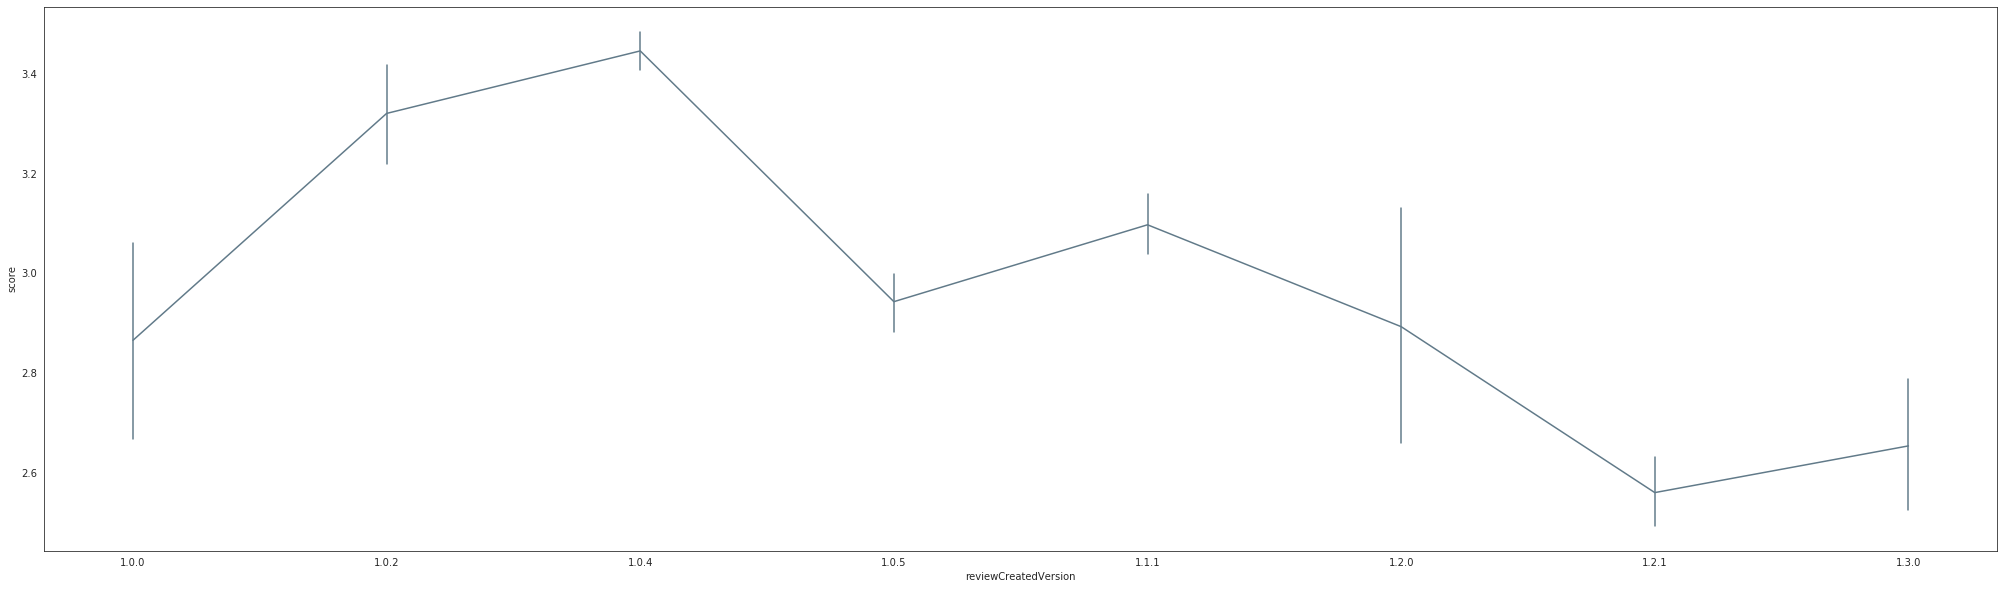

In [9]:
plt.figure(figsize=(35,10))

mycolors = ["#617a89", "#0b53c1", "#ff0055", "#b3e93e", "#909495", "#ffec1b", "#fba29d", "#23d0fc", "#fda609", "#7f0799", "#650d1b"]
sns.set_palette(sns.color_palette(mycolors))
sns.set_style("white")
sns.lineplot(x = "reviewCreatedVersion", y = "score", err_style = "bars", ci = 95, data = df_version_filter)

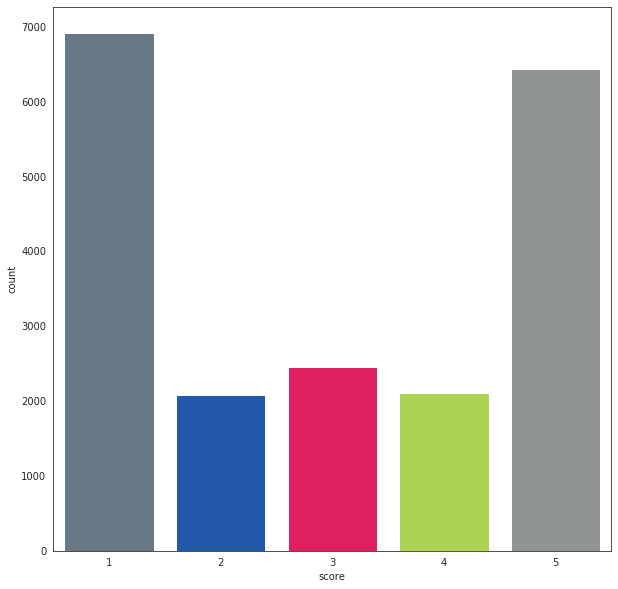

In [10]:
# count of scores given
plt.figure(figsize=(10,10))
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))
sns.countplot(x = "score", data = df)

Hier fällt auf, dass es in den Reviews zwei Lager zu geben scheint: Leute, die die App schlecht bewerten, und Leute, die die App besonders gut bewerten. Die Gründe für die schlechten Bewertungen möchten wir uns später genauer ansehen. Uns interessiert besonders, welche Wörter und Themen sich in den schlechten Reviews finden lassen.

# Lemmatisierung

Um Reviews besser miteinander vergleichen zu können, ist es wichtig, diese sprachlich "auf einen Nenner" zu bringen. Dazu werden alle Wörter mithilfe des TreeTaggers in den Reviews lemmatisiert, sodass diese dieselbe Grundform miteinander teilen.

In [11]:
import treetaggerwrapper
tagger = treetaggerwrapper.TreeTagger(TAGLANG = 'de', TAGDIR = '/home/sebastian/Programme/TreeTagger/')

In [12]:
# tagger example #1
tag_ex = tagger.tag_text("Täglich grüßt das Murmeltier.", tagonly = False)

tags2 = treetaggerwrapper.make_tags(tag_ex)
tags2
tag_list = list(list(zip(*tags2))[2])
tag_list

['täglich', 'grüßen', 'die', 'Murmeltier', '.']

In [13]:
def preprocess_text(text_column):

    # replace dot to fully identify tokens
    text_long = str(text_column).replace(".", " ")
    # set dummy text for problematic rows
    if text_long == "   ":
        text_long = "Pythagoras"

    # tag sentence
    tags = tagger.tag_text(text_long, tagonly = False)
    tags2 = treetaggerwrapper.make_tags(tags)

    tag_tuple_list = []
    for element in tags2:
        if len(element) == 3:
            tag_tuple_list.append(element)
        else:
            next

    tag_list = list(list(zip(*tag_tuple_list))[2])
    
    # store in on long text variable
    text_long = ""
    for val in tag_list:
        text_long = text_long + str(val) + ' '

    # lower all characters
    tokens = text_long.split()
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()

    # store in on long text variable
    text_long = ""
    for words in tokens: 
        text_long = text_long + words + ' '
    
    return text_long

In [14]:
# tagger exmaple #2
df_test = df.copy()
df_test.reset_index(inplace = True)
df_test = df_test.loc[5500:5520]
df_test["LemmaReview"] = df_test.content.apply(preprocess_text)
df_test.LemmaReview

5500                                          sehr gut ! 
5501                                           nicht gut 
5502                                            sehr gut 
5503    nach anfänglich schwierigkeit bei die risikoer...
5504                                  laufen einwandfrei 
5505    eine sehr sehr gut app ! 👍👍nur sie braut zieml...
5506    keine problem mit dies app täglich aktualisier...
5507    haben handy mit prepaid karte klappen es auch ...
5508    big brother sein watching you all nur lug und ...
5509                        alle super ! unverzichtbar ! 
5510                                       sein schlecht 
5511    fehler @card@ und @card@ sein beseitigt jetzt ...
5512    bei ich sein es “ fehler bei kommunikation mit...
5513                                      wieder löschen 
5514                                  laufen einwandfrei 
5515    app sein wohl in die aktuell version drauf , a...
5516                            gehen auf mein p30 prima 
5517          

In [15]:
df["LemmaReview"] = df.content.apply(preprocess_text)

# Wordcloud

Wordclouds sind schnell und einfach zu implementieren und können hilfreich dabei sein, einen Überblick über häufige Wörter zu bekommen. Da wir uns Reviews mit schlechten Bewertungen ansehen möchten, betrachten wir Wordclouds für Reviews mit "schlechten", "neutralen" und "guten" Bewertungen.

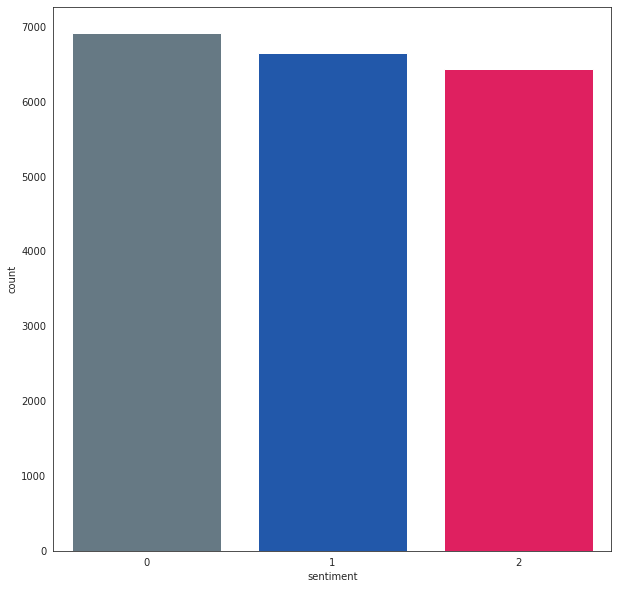

In [16]:
# assign "sentiment" to scores
def to_sentiment(rating):
    rating = int(rating)
    if rating == 1:
        return 0
    elif rating >= 2 and rating <= 4:
        return 1
    else:
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

# how many "bad", "neutral" and "good" sentiments are there?
plt.figure(figsize=(10,10))
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))
sns.countplot(df.sentiment)

In [17]:
df.sort_values(["score","thumbsUpCount"], ascending = False).iloc[0:5,[3,4,5,10]]

,content,score,thumbsUpCount,LemmaReview
7746,Solide App obwohl offenbar noch ein paar Bugs ...,5,771,solide app obwohl offenbar noch eine paar bug ...
17947,Die App tut das was sie verspricht. Anfangs ha...,5,474,die app tun die was sie versprechen anfang hab...
17786,Super App! Jeder der schon einmal eine App ent...,5,356,super app ! jede die schon einmal eine app ent...
9662,Gute einfach zu nutzende App. Datenschutz sehr...,5,349,gute einfach zu nutzend app datenschutz sehr h...
18380,"Die App tut bei mir das was es soll, ist klar ...",5,344,"die app tun bei ich die was es sollen , sein k..."


In [18]:
df.sort_values(["score"], ascending = True).iloc[0:5,[3,4,5,10]].sort_values(["thumbsUpCount"], ascending = False)

,content,score,thumbsUpCount,LemmaReview
5120,Nach dem Update auf Version 1.1.1 und installi...,1,12,nach die update auf version @card@ @card@ @car...
5118,Und schon wieder etwas ist schief gelaufen. Ur...,1,2,und schon wieder etwas sein schief laufen ursa...
11872,"Ich habe das gleiche Problem, wie zig andere N...",1,1,"ich haben die gleich problem , wie zig andere ..."
10734,Direkt Fehler aber jetzt mal Butter bei die Fi...,1,0,direkt fehler aber jetzt mal butter bei die fi...
10740,Hallo mit meinen Tablett in Wi-Fi geht die App...,1,0,hallo mit mein tablett in wi-fi gehen die app ...


In [19]:
# length of each post
def to_review_length(review):
    review = len(review)
    return review

df["ReviewLength"] = df.content.apply(to_review_length)

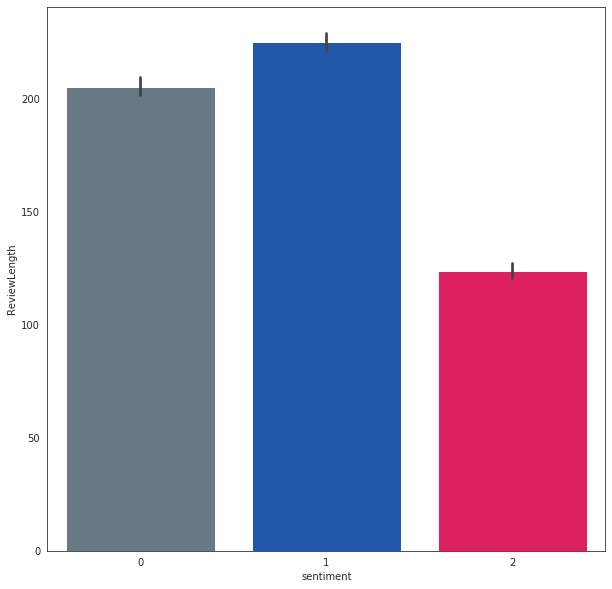

In [20]:
# plot length of reviews based on their sentiments 
plt.figure(figsize=(10,10))
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))
sns.barplot(y = "ReviewLength", x = "sentiment", data = df)

In [21]:
def to_long_string(text_column):
    # store in one long text variable
    text_long = ""
    for word in text_column:
        text_long = text_long + str(word) + ' '
    return text_long

In [22]:
review_bad = to_long_string(df[df["sentiment"] == 0].LemmaReview)
review_neutral = to_long_string(df[df["sentiment"] == 1].LemmaReview)
review_good = to_long_string(df[df["sentiment"] == 2].LemmaReview)

In [23]:
def wordcloud_spec(text, colors):

    # import modules
    from wordcloud import WordCloud
    from nltk.corpus import stopwords
    import numpy as np
    from PIL import Image
    
    # add mask
    virus_mask = np.array(Image.open("virus.png"))
    
    # stopwords
    german_stop_words = stopwords.words('german')
    stoplist = list(set(german_stop_words))
    stop_words = ["card", "tag", "card ", "app"] + stoplist
    
    # specify cloud
    specification = WordCloud(
            mask = virus_mask,
            width = 1000,
            height = 1000,
            background_color = 'white',
            colormap = colors,
            stopwords = stop_words,
            max_words = 300,
            collocations = False,
            min_font_size = 5).generate(text)

    return specification

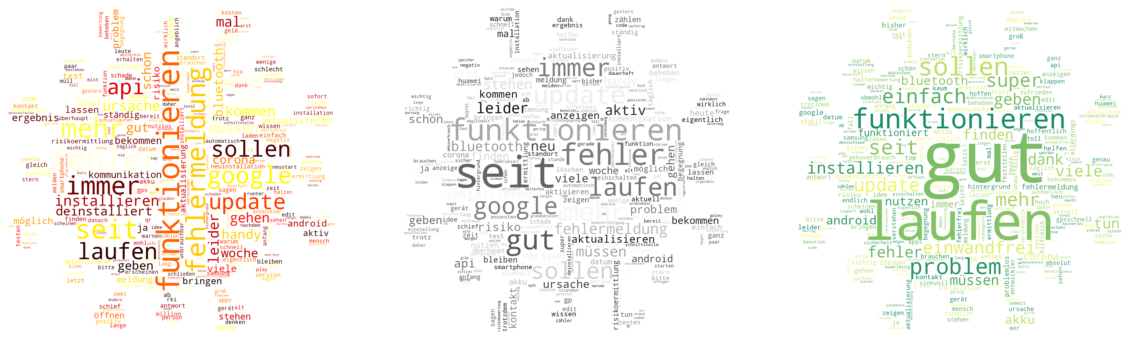

In [24]:
wordcloud_bad = wordcloud_spec(review_bad, matplotlib.cm.hot)
wordcloud_neutral = wordcloud_spec(review_neutral, matplotlib.cm.binary)
wordcloud_good = wordcloud_spec(review_good, matplotlib.cm.summer)

# plot the WordCloud image
f = plt.figure(figsize = (20,15))

f.add_subplot(1,3, 1)
plt.imshow(wordcloud_bad, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 2)
plt.imshow(wordcloud_neutral, interpolation = 'bilinear')
plt.axis("off")

f.add_subplot(1,3, 3)
plt.imshow(wordcloud_good, interpolation = 'bilinear')
plt.axis("off")

plt.show()

Wie zu erwarten, zeigen sich sich in der Wörterwolke für Reviews mit schlechten Bewertungen eher Wörter, die für eine nicht solide Funktionsweise der App sprechen. Interessanterweise finden sich auch einige dieser Wörter auch in den "neutralen" Bewertungen wieder. Das ist nicht ganz verwunderlich, wenn man bedenkt, dass Apps wohl nur dann eine Bewertung mti voller Punktzahl erlangen, wenn diese wirklich reibungslos funktionieren. Da Wörterwolken im Vergleich zum Topic Modeling nur wenig neue Erkenntnisse liefern, widmen wir uns nun diesem Teil.

# Topic modeling bei Reviews mit schlechter Bewertung

In [25]:
# https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd?source=user_profile---------8-----------------------
# https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
# https://levelup.gitconnected.com/natural-language-processing-and-topic-modeling-on-user-review-dataset-66599beaa50e
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
# https://medium.com/airy-science/gain-insights-from-customers-review-using-topic-modelling-2ae632be202b

In [26]:
df_bad = df[df.score == 1].copy()

In [27]:
# https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/
from sklearn.feature_extraction.text import TfidfVectorizer

# stopwords
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
stoplist = list(set(german_stop_words))
stop_words_german = ["card", "tag", "card ", "app"] + stoplist

tfidf_vectorizer = TfidfVectorizer(
    max_df = 0.99, # max_df : maximum document frequency for the given word
    max_features = 1000, # max_features: maximum number of words (columns)
    min_df = 0.01, # min_df : minimum document frequency for the given word
    use_idf = True, # use_idf: if not true, we only calculate tf
    stop_words = stop_words_german,
    ngram_range = (1,1) # ngram_range: (min, max), eg. (1, 2) including 1-gram, 2-gram
)

In [28]:

fitted_vectorizer_bad = tfidf_vectorizer.fit_transform(df_bad.LemmaReview)
# https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb

from sklearn.decomposition import LatentDirichletAllocation
lda_tfidf_bad = LatentDirichletAllocation(n_components = 9, random_state = 15)
lda_tfidf_bad.fit(fitted_vectorizer_bad)

import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tfidf_bad, fitted_vectorizer_bad, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.170739  0.055577       1        1  20.399920
1     -0.057323  0.084001       2        1  13.285698
5     -0.032084 -0.058324       3        1  12.202037
2      0.072788 -0.200490       4        1  11.796155
7     -0.061404  0.002296       5        1   9.521356
0     -0.156849 -0.031862       6        1   8.641037
3      0.036076  0.083302       7        1   8.477643
8      0.261837  0.078567       8        1   7.908382
6      0.107699 -0.013066       9        1   7.767771, topic_info=              Term        Freq       Total Category  logprob  loglift
140           müll  104.000000  104.000000  Default  30.0000  30.0000
61        ergebnis  123.000000  123.000000  Default  29.0000  29.0000
15             api  176.000000  176.000000  Default  28.0000  28.0000
136        million  101.000000  101.000000  Default  27.0000  27.0000
179       schlecht  108.000000  108.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
73   funktionieren   19.734410  413.370801   Topic9  -4.2209  -0.4868
66            erst   14.185795   97.707847   Topic9  -4.5510   0.6254
223          viele   14.855208  134.230449   Topic9  -4.5049   0.3540
141         müssen   13.243956  159.462012   Topic9  -4.6197   0.0669
37          corona   12.661993  155.784319   Topic9  -4.6647   0.0453

[399 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.409422         ab
0         2  0.260542         ab
0         3  0.024813         ab
0         5  0.210915         ab
0         6  0.037220         ab
...     ...       ...        ...
247       4  0.113291  überhaupt
247       6  0.016184  überhaupt
247       7  0.566453  überhaupt
247       8  0.064737  überhaupt
247       9  0.016184  überhaupt

[1380 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 6, 3, 8, 1, 4, 9, 7])

Hier ergeben sich interessante und teils distinkte Themen, die sich aus den schlechten Bewertungen herauslesen ließen. Auffällig sind unter anderem Reviews, die sich nicht konkret auf die App beziehen, sondern diese als "Steuerverschwendung" bezeichnen. Es finden sich auch Themen bezüglich fehlerhafter APIs und Kompatbilitätsprobleme mit Huawei und Samsung-Geräten. Wir betrachten nun die Anzahl der zugeteilten Reviews zu diesen Themen sowie ihre Top-Wörter, um diese Themen besser beschreiben zu können.

In [38]:
## assign topics to reviews
topic_dist_bad = lda_tfidf_bad.transform(fitted_vectorizer_bad)

# get index with maximum value in a row of a numpy array
import numpy as np
topics_bad_max = np.argmax(topic_dist_bad, axis = 1)

# reset index
df_bad = df_bad.reset_index()

# because Python counts from 0 instead of 1 we will add 1 and assign the series to the existing data frame
df_bad["topic"] = pd.Series(topics_bad_max + 1)

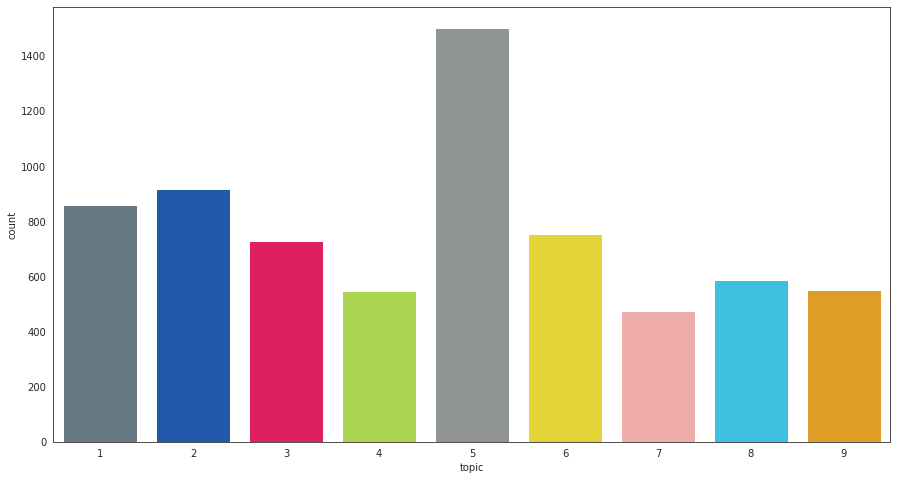

In [39]:
plt.figure(figsize=(15,8))
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))
sns.countplot(x = "topic", data = df_bad)

In [40]:
toptable = pyLDAvis.sklearn.prepare(lda_tfidf_bad, fitted_vectorizer_bad, tfidf_vectorizer)
toptable = toptable.token_table

In [41]:
toptable[toptable["Topic"] == 8].sort_values(["Freq"], ascending = False)

,Topic,Freq,Term
term,,,
140,8,0.994507,müll
67,8,0.970836,euro
200,8,0.935767,steuergeld
136,8,0.916416,million
114,8,0.881907,kosten
...,...,...,...
238,8,0.007195,woche
94,8,0.006591,handy
123,8,0.005652,leider


In [42]:
# collect 10 top words in topics
dict_top = dict()
for topic_id in range(1,10):
    top_id = toptable[toptable["Topic"] == topic_id].sort_values(["Freq"], ascending = False)
    dict_top[topic_id] = list(top_id.Term.iloc[0:10])

In [43]:
for topic in dict_top:
    terms = dict_top[topic]
    print(topic, terms)

1 ['schief', 'kommunikation', 'api', 'schieflaufen', 'schnittstelle', 'play', 'ursache', 'google', 'fehler', 'erscheinen']
2 ['alt', 'schließen', 'deinstallation', 'sofort', 'installation', 'gerät', 'einstellung', 'gerne', 'huawei', 'samsung']
3 ['ermittlung', 'standort', 'gps', 'begegnung', 'dauerhaft', 'risiko', 'benachrichtigung', 'mögen', 'bluetooth', 'aktivieren']
4 ['test', 'code', 'testergebnis', 'ergebnis', 'qr', 'arzt', 'negativ', 'positiv', 'quarantäne', 'testen']
5 ['tagen', 'leer', 'runter', 'laden', 'akku', 'hoch', 'stunde', 'stunden', 'idee', 'schnell']
6 ['schlecht', 'aktualisierung', 'risikoermittlung', 'täglich', 'aktualisieren', 'nie', 'möglich', 'zwei', 'obwohl', 'anfang']
7 ['schrott', 'mist', 'zählen', 'sap', 'updates', 'vertrauen', 'regierung', 'groß', 'hintergrund', 'überhaupt']
8 ['müll', 'euro', 'steuergeld', 'million', 'kosten', 'total', 'sinnlos', 'dafür', 'wer', 'geld']
9 ['genug', 'unnötig', 'nein', 'lange', 'deutschland', 'gelöscht', 'funktioniert', 'halte

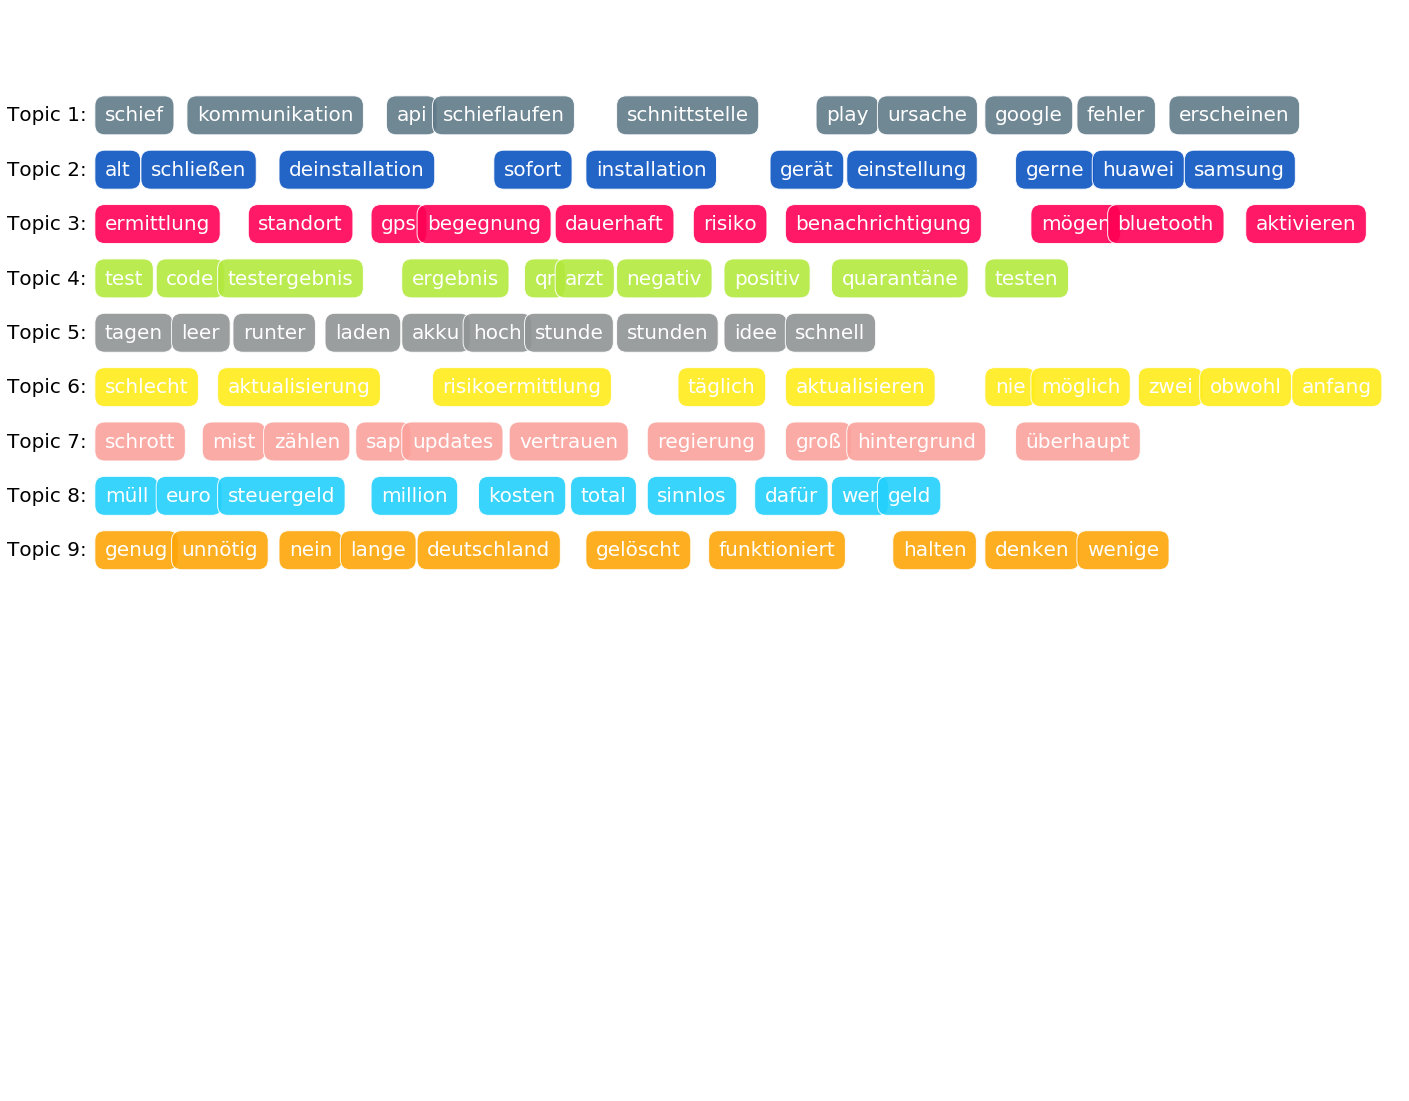

In [44]:
# set aesthetics
fig, ax = plt.subplots(figsize = (25,20))
ax.axis('off')
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))

# print top words for each topic
word_position_h = 0.07
word_position_v = 0.90
for topic in dict_top:
        ax.text(0, word_position_v,
                "Topic {}:".format(topic),
                verticalalignment = 'center',
                horizontalalignment = 'left',
                transform = ax.transAxes,
                color = "black",
                fontsize = 20,
                fontweight = 500)
        terms = dict_top[topic]
        for word in terms:
                ax.text(word_position_h, word_position_v,
                        word,
                        verticalalignment = 'center',
                        horizontalalignment = 'left',
                        transform = ax.transAxes,
                        color = "white",
                        fontsize = 20,
                        fontweight = 500,
                        bbox = {'facecolor': mycolors[topic-1], 'alpha': 0.9, 'pad': 0.5,  "boxstyle": 'round',})
                word_position_h += .011 * len(word)
        word_position_h = 0.07
        word_position_v -= 0.05

Anhand der nun vorliegenden zehn Top-Wörtern, können wir jedes Thema mit einer Überschrift versehen. Die nun folgendenen Themenvorschläge sind gewiss nicht zu 100 % akkurat, doch spiegeln sie ungewähr deren Inhalt wieder. Mithilfe eines einfachen Kuchendiagramms können wir nun sehen, wie häufig manche Probleme im Vergleich zu anderen Problemen auftraten.

[Text(0.5, 1.0, 'Summary of topics in reviews with score = 1'), None]

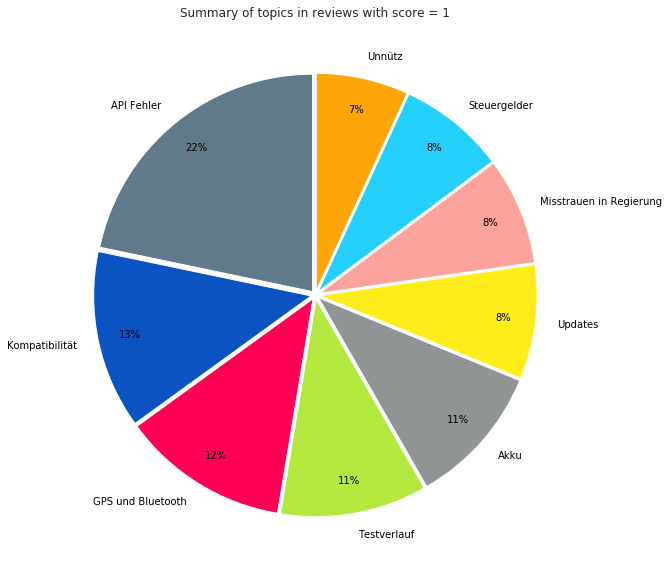

In [45]:
labels = ["API Fehler", "Kompatibilität", "GPS und Bluetooth", "Testverlauf", "Akku", "Updates", "Misstrauen in Regierung", "Steuergelder", "Unnütz"]
explode = [0.02] * len(labels)

# set aesthetics
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
sns.set_style("white")
sns.set_palette(sns.color_palette(mycolors))

ax.pie(df_bad.topic.value_counts(),
        startangle = 90,
        colors = mycolors,
        wedgeprops = {'edgecolor': 'white'},
        labels = labels,
        autopct = '%1.f%%',
        shadow = False,
        pctdistance = 0.85,
        textprops = dict(color = "black", fontweight = 500),
        explode = explode,
        )
ax.set(aspect = "equal", title = 'Summary of topics in reviews with score = 1')

# Schlussfolgerung

Wie sich zeigt, finden sich in circa zwei Drittel / drei Viertel der Reviews mit schlechten Bewertungen Themen wieder, die technische Probleme (API, Kompatibilität mit Geräten, Updates und Akkuverbrauch) thematisieren. Es wird als lohnenswert erachtet, diese Themenbereiche sich nun genauer zu widmen. Beispielsweise könnte nun in einem weiteren Schritt die relativen Anteile der Problembereiche für jede App-Version untersucht werden um zu visualisieren, welche Probleme mit der Zeit zu- und abnahmen. Auch kann in Betracht gezogen werden, Reviews mit der Anzahl an erhaltenden "Votes" diese zu gewichten. Ein Drittel / ein Viertel der Bewertungen hingegen sind, wohlgemerkt nur auf den ersten Blick, auf inhaltliche Kritikpunkte der Corona-Warn-App oder dergleichen zurückzuführen.